# Section 4: Eigenvalues, Eigenvectors, and the Rayleigh Quotient

In lecture you have been discussing eigenvectors and Eigenvalues, diagonalizable matrices, spectral decomposition, power iterations (Lanczos), and generalizing the idea of functions to matrices.

Essentially, the eigenvectors are an orthonormal basis for your matrix (remember section 3?) and the Eigenvalues describe the characteristic of the matrix.

In this section, we will use the spectral decomposition and the singular value decomposition as a tool for dimensionality reduction and compression.

## Principle Component Analysis (PCA)

Here we will learn how to use `scipy` to decompose a matrix into its spectral components and use those components to describe the matrix.

One common technique in data analysis is called Principle Component Analysis (PCA). This technique involves the spectral decomposition of the covariance matrix of the data. In the next section, we will see how this relates to the Singular Value Decomposition of the data matrix.

Let's proceed by taking a subset of the MNIST observations. In the code below, I have filtered the train data to only have 'ones' and 'fives' in the new dataset. Then, I have calculated the covariance of this new data and decomposed it into eigenvectors and values using `scipy`.

The eigenvectors of a covariance are referred to as 'principle axes' and the magnitude of the projections of observations onto these axes are referred to as 'principle components' in PCA. These principle axes for a basis for a low dimensional space which we project the data into.

(60000, 28, 28)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[5 0 4 ... 5 6 8]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[5 1 1 ... 5 1 5]
shapes: (12163, 784) and (12163,)


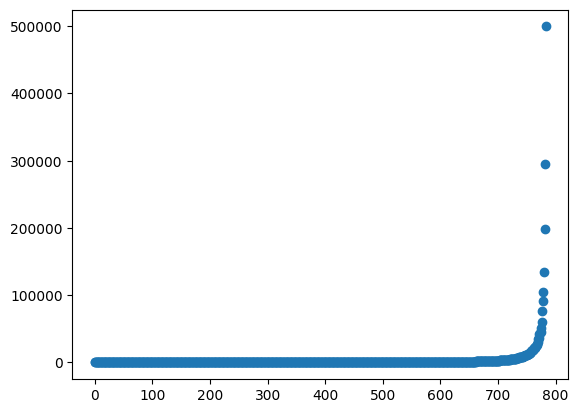

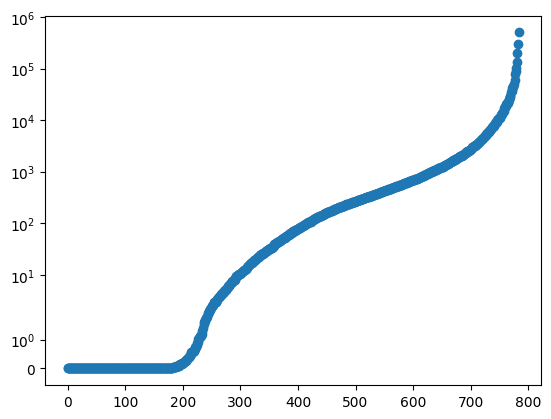

(60000, 28, 28)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[5 0 4 ... 5 6 8]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[5 1 1 ... 5 1 5]
shapes: (12163, 784) and (12163,)


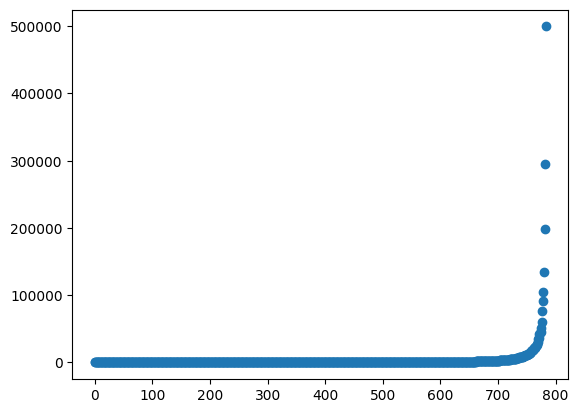

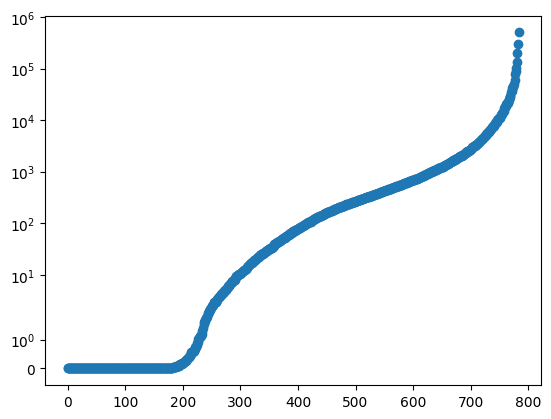

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import HTML
from matplotlib import animation

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)
x_train = x_train.reshape((60000, 784))
print(x_train)
print(y_train)

# filter is a vector with true where there is a 1 or a 5 in y_train[i]
filter = np.logical_or((y_train == 1), (y_train == 5))
data = x_train[filter]
print(data)
labels = y_train[filter]
print(labels)

print(f'shapes: {data.shape} and {labels.shape}')

cov = np.cov(data, rowvar=False)
eigs, Q = scipy.linalg.eigh(cov)
x = np.arange(len(eigs))

plt.scatter(x, eigs)
plt.show()

plt.scatter(x, eigs)
plt.yscale('symlog')
plt.show()

Here I have plotted the eigenvalues with a linear and log y axis. For PCA to be effective, we would like to capture most of the 'information' with less eigenvectors than dimension of our observations.

These plots show that the first few largest magnitude eigenvectors (last 3 columns of `Q`) can mostly describe the covariance between pixels in our dataset.

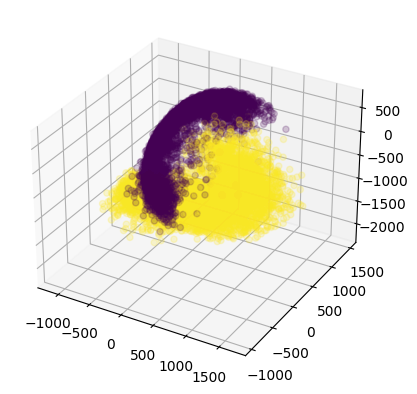

In [4]:
principle_components = data @ Q[:,-3:]

# 3d projection
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(principle_components[:,0], principle_components[:,1], principle_components[:,2], c=labels, alpha=0.2)
plt.show()

# NOTE: producing the animated video takes a long time... (about 2 minutes)
# set this to False for stationary projection
animate_plot = True

if animate_plot:
  def animate(frame):
    ax.view_init(30, frame)
    plt.pause(.001)
    return fig

  anim = animation.FuncAnimation(fig, animate, frames=360, interval=50)

In [7]:
# WARNING: this is the block that actually takes a long time
# Give it a couple minutes....
HTML(anim.to_html5_video())

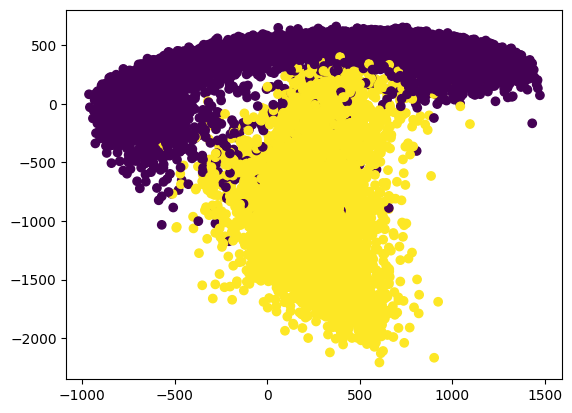

In [8]:
# 2d projection
plt.scatter(principle_components[:,1], principle_components[:,2], c=labels)
plt.show()

Here I have plotted the data matrix projected into a 3 dimensional and 2 dimensional space using the principle axes as a basis. The color denotes if it is a 1 or a 5. We can see a clear decision boundary between the two classes we selected. Based on the distribution of the scatter, can you guess which color is which label?

Often times in machine learning we would like to find a decision boundary to classify observations in a high dimensional space (like MNIST, dimension 784). It is much easier to model lower dimensional data. Instead of modeling the raw images we could learn to classify an observation based on its principle components. This is the power of dimensionality reduction techniques such as PCA.

### Homework 4.1

*   Calculate and plot the eigenvalues when selecting 3 or more different classes of observations on top of the previous plot. Comment on how the distribution of the spectrum differs from the example with only 2 observations (1 and 5).
*   Are there classes in this data set you think wouldn't demonstrate such a clean decision boundary? Plot the low dimensional embeddings for these classes and see if they have more overlap.

In [ ]:
# Your code here

## Truncated SVD

Often times we have matrix data that is stored in a low rank format. We can compress the matrix in a lossy or lossless way using truncated SVD to require less memory.

Let's look to our old friend, MNIST, for a practical example. MNIST naturally has a lot of row and column dependency. Remember that in MNIST, rows are observations and columns correspond to individual pixels.

Some examples of column dependency in our data is the corners of the images are likely white and full of zeros. These corners could be removed from the dataset without much loss (hence the dependency).

Row dependency is produced because there are only 10 classes within 60,000 images. Images within a class are quite similar and produce the row dependence.

We could use truncated SVD to compress our dataset and eliminate much of the dependence.

In [7]:
import numpy as np
import scipy
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape((60000, 784))

U, s, V_t = scipy.linalg.svd(x_train, full_matrices=False)

In [ ]:
x = np.arange(len(s))

plt.scatter(x, s)
plt.show()

plt.scatter(x, s)
plt.yscale('symlog')
plt.show()

By plotting the singular values much like we did the eigenvalues in the previous section we see that there is only a small amount of *strictly* dependent data but a significant amount that is 'almost dependent'.

I'll try taking the first 50 rows of the left vectors and the first 50 columns of the right vectors (only 12.7% of the size of the original data).

In [ ]:
size = 50
reconstruction = U[:,:size] @ np.diag(s[:size]) @ V_t[:size,:]

# plot some random images to see how they look
ids = np.random.randint(60000, size=10)

fig, axs = plt.subplots(2, 10)


for i, id in enumerate(ids):
  original = x_train[id]# plot the sample
  compressed = reconstruction[id]
  axs[0, i].imshow(original.reshape(28, 28), cmap='gray')
  axs[1, i].imshow(compressed.reshape(28, 28), cmap='gray')
plt.show()

error = x_train - reconstruction
sum_squared_error = np.linalg.norm(error.flatten())
print(f'error norm: {sum_squared_error ** 0.5}')

### Homework 4.2

*   Apply SVD to the data matrix but filtered on a single label. Truncate the SVD using the same number of vectors as I did above and reconstruct some images.

*   When isolating the dataset to a single observation class, does the reconstruction improve?

*   Calculate the error norm between your reconstructed data and the original dataset. Also filter the truncated `U` from my example on the same label you selected for the first two steps, reconstruct the data using that filtered `U` and my truncated `s` and `V_t`. Calculate the error of this reconstruction. Which is worse?

*   Do the previous step in a loop over each label class and calculate the sum of the sum squared errors. Compare that to my total sum squared error. How much improvement is there? How much more total memory did you use?

In [ ]:
# Your code here